# 1트 (73.10%)
MNIST 하던 대로, 다만 은닉층을 좀 더 깊게

In [ ]:
!pip install torchmetrics

from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
import torchmetrics
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from math import *
from copy import deepcopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/ml-class-rhseung/data/'
# data_dir = './data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

Mounted at /content/drive


device(type='cuda')

In [ ]:
train_and_valid_dset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_dset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class_maps = train_and_valid_dset.classes

X = np.array(train_and_valid_dset.data).transpose(0, 3, 1, 2)
Y = np.array(train_and_valid_dset.targets)

X.shape, Y.shape

((50000, 3, 32, 32), (50000,))

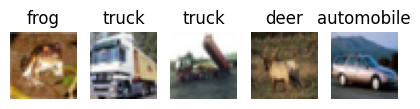

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2))

for i in range(ax.shape[0]):
    ax[i].imshow(X[i].transpose(1, 2, 0))   # .imshow 는 (32, 32, 3) 형식으로 받아야 한다고 함
    ax[i].set_title(class_maps[Y[i]])
    ax[i].axis('off')

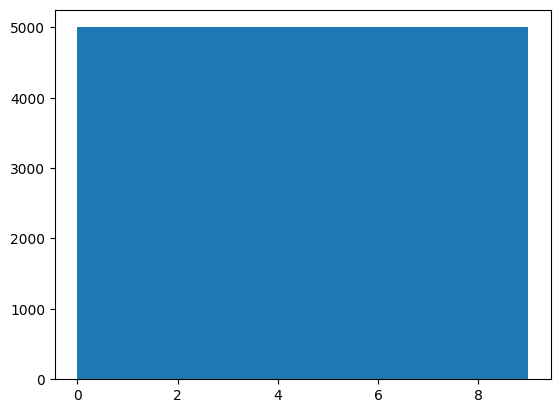

In [ ]:
plt.hist(Y)
plt.show()

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=224, stratify=Y)

X_train.shape, Y_train.shape

((40000, 3, 32, 32), (40000,))

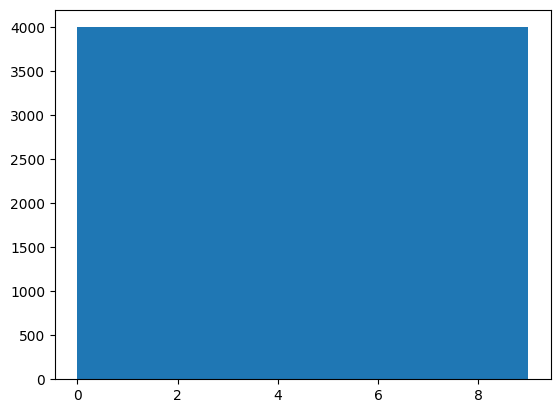

In [ ]:
plt.hist(Y_train)
plt.show()

In [ ]:
X_train = X_train / 255
X_valid = X_valid / 255

X_train.max()

1.0

In [ ]:
X_test = torch.FloatTensor(np.array(test_dset.data).transpose(0, 3, 1, 2)).to(device) / 255
Y_test = torch.LongTensor(test_dset.targets).to(device)

X_test.max()

tensor(1., device='cuda:0')

In [ ]:
class CIFAR10Dataset(Dataset):
    def __init__(self, X_data, Y_data, device=torch.device('cpu')):
        self.X = torch.FloatTensor(X_data).to(device)
        self.Y = torch.LongTensor(Y_data).to(device)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        if not isinstance(item, int):
            raise TypeError

        return self.X[item], self.Y[item]

train_dset = CIFAR10Dataset(X_train, Y_train, device=device)
valid_dset = CIFAR10Dataset(X_valid, Y_valid, device=device)

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
list(map(lambda p: p.shape, next(iter(train_loader))))

[torch.Size([32, 3, 32, 32]), torch.Size([32])]

In [ ]:
def model_maker():
    return nn.Sequential(
        # [-1, 3, 32, 32] -> [-1, 64, 16, 16]
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [-1, 64, 16, 16] -> [-1, 256, 8, 8]
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [-1, 256, 8, 8] -> [-1, 256*8*8]
        nn.Flatten(start_dim=1),

        # [-1, 256*8*8] -> [-1, 10]
        nn.Linear(256*8*8, 256),
        nn.Linear(256, len(class_maps)),
    ).to(device)

model = model_maker()
cost = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(X[0].shape)
torchsummary.summary(model, X[0].shape)

(3, 32, 32)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
              ReLU-9          [-1, 256, 16, 16]               0
        MaxPool2d-10            [-1, 256, 8, 8]               0
          Flatten-11                [-1, 16384]               0
           Linear-12                  [-1, 256]       4,194,560
           Linear-13                   [-1, 10]           2,570
Total params: 4,585,546
Tra

In [ ]:
epochs = 15

best_epoch = -1
best_model_state = None
best_valid_loss = inf

for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as train:
        for x, y in train:
            train.set_description(f"Train (Epoch {epoch + 1:02d})")

            optimizer.zero_grad()
            predict = model(x)
            loss = cost(predict, y)
            loss.backward()
            optimizer.step()

            train.set_postfix(loss=loss.item())

    with tqdm(valid_loader, unit='batch') as valid:
        batch_loss = 0

        for x, y in valid:
            valid.set_description(f"Valid (Epoch {epoch + 1:02d})")

            with torch.no_grad():
                predict = model(x)
                loss = cost(predict, y)
                batch_loss += loss.item() / len(valid)

            valid.set_postfix(loss=batch_loss, best_epoch=best_epoch + 1)

        if (not best_model_state) or batch_loss < best_valid_loss:
            best_epoch = epoch
            best_model_state = deepcopy(model.state_dict())
            best_valid_loss = batch_loss

print(f"\n\nBest Epoch: {best_epoch + 1} [loss={best_valid_loss}]")
torch.save(best_model_state, 'best_model.pth')

Valid (Epoch 15): 100%|██████████| 312/312 [00:01<00:00, 159.35batch/s, best_epoch=5, loss=1.69]




Best Epoch: 5 [loss=0.8121935328803003]


In [ ]:
best_model = model_maker()
best_model.load_state_dict(torch.load('best_model.pth'))

with torch.no_grad():
    output = best_model(X_test)
    predict = output.argmax(dim=1)
    is_correct = predict == Y_test

    print(f"Accuracy: {is_correct.float().mean()}")

Accuracy: 0.7310000061988831


# 2트 (53.27%)
1트 + 이미지 정규화

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from google.colab import drive
import numpy as np

drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/ml-class-rhseung/data/'
# data_dir = './data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cuda')

In [ ]:
tmp_data = datasets.CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

X_tmp = tmp_data.data / 255

X_tmp.shape

Files already downloaded and verified


(50000, 32, 32, 3)

In [ ]:
r = X_tmp[:, :, :, 0]
g = X_tmp[:, :, :, 1]
b = X_tmp[:, :, :, 2]
channels = [r, g, b]
mean = [x.mean() for x in channels]
std = [x.std() for x in channels]

mean, std

([0.49139967861519745, 0.4821584083946076, 0.44653091444546616],
 [0.2470322324632823, 0.24348512800005553, 0.2615878417279641])

In [ ]:
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.ToPILImage(),
])

In [ ]:
train_data = datasets.CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=normalize
)

X = train_data.data / 255
Y = np.array(train_data.targets)
class_maps = train_data.classes

X.shape, Y.shape

Files already downloaded and verified


((50000, 32, 32, 3), (50000,))

dataset.data는 transform 되기 전의 원본 데이터를 의미하는구나

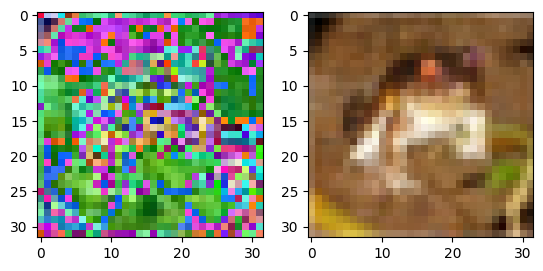

In [ ]:
import matplotlib.pyplot as plt

img, label = next(iter(train_data))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(train_data.data[0])

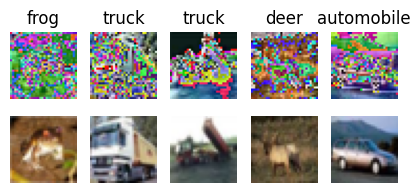

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize=(5, 2))

for i in range(ax.shape[1]):
    ax[0, i].imshow(normalize(X[i]))
    ax[0, i].axis('off')
    ax[0, i].set_title(class_maps[Y[i]])

    ax[1, i].imshow(X[i])
    ax[1, i].axis('off')

plt.show()

In [ ]:
X = np.array([np.asarray(normalize(a)) / 255 for a in X]).transpose(0, 3, 1, 2)
X.shape

(50000, 3, 32, 32)

In [ ]:
from sklearn.model_selection import train_test_split

test_data = datasets.CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=normalize
)

X_test = test_data.data / 255
X_test = np.array([np.asarray(normalize(a)) / 255 for a in X_test]).transpose(0, 3, 1, 2)
Y_test = np.array(test_data.targets)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=224, stratify=Y)

print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_valid: {X_valid.shape}, Y_valid: {Y_valid.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

Files already downloaded and verified
X_train: (40000, 3, 32, 32), Y_train: (40000,)
X_valid: (10000, 3, 32, 32), Y_valid: (10000,)
X_test: (10000, 3, 32, 32), Y_test: (10000,)


In [ ]:
X_train.max(), X_valid.max(), X_test.max()

(1.0, 1.0, 1.0)

In [ ]:
from torch.utils.data import DataLoader, Dataset

class CIFAR10Dataset(Dataset):
    def __init__(self, X_data, Y_data, device=torch.device('cpu')):
        self.X = torch.FloatTensor(X_data).to(device)
        self.Y = torch.LongTensor(Y_data).to(device)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        if not isinstance(item, int):
            raise TypeError

        return self.X[item], self.Y[item]

train_dset = CIFAR10Dataset(X_train, Y_train, device=device)
valid_dset = CIFAR10Dataset(X_valid, Y_valid, device=device)

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
list(map(lambda p: p.shape, next(iter(train_loader))))

[torch.Size([32, 3, 32, 32]), torch.Size([32])]

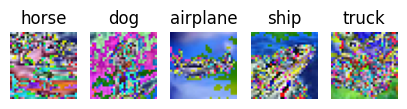

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2))

for i in range(ax.shape[0]):
    ax[i].imshow(X_train[i].transpose(1, 2, 0))   # .imshow 는 (32, 32, 3) 형식으로 받아야 한다고 함
    ax[i].set_title(class_maps[Y_train[i]])
    ax[i].axis('off')

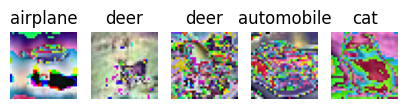

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2))

for i in range(ax.shape[0]):
    ax[i].imshow(X_valid[i].transpose(1, 2, 0))   # .imshow 는 (32, 32, 3) 형식으로 받아야 한다고 함
    ax[i].set_title(class_maps[Y_valid[i]])
    ax[i].axis('off')

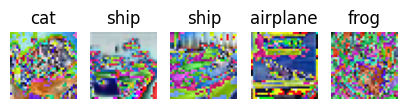

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2))

for i in range(ax.shape[0]):
    ax[i].imshow(X_test[i].transpose(1, 2, 0))   # .imshow 는 (32, 32, 3) 형식으로 받아야 한다고 함
    ax[i].set_title(class_maps[Y_test[i]])
    ax[i].axis('off')

In [ ]:
import torch.optim as optim
import torchsummary
from tqdm import tqdm
from math import *
from copy import deepcopy

def ConvLayer(in_channels, hidden_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

def model_maker():
    # return nn.Sequential(
    #     # [-1, 3, 32, 32] -> [-1, 256, 4, 4]
    #     ConvLayer(3, 16, 32),
    #     ConvLayer(32, 64, 128),
    #     ConvLayer(128, 128, 256),

    #     nn.Flatten(start_dim=1),

    #     # [-1, 128*8*8] -> [-1, 10]
    #     nn.Linear(256*4*4, 256*4),
    #     # nn.ReLU(),
    #     nn.Linear(256*4, 256),
    #     # nn.ReLU(),
    #     nn.Linear(256, len(class_maps)),
    #     # nn.ReLU()
    # )

    return nn.Sequential(
        # [-1, 3, 32, 32] -> [-1, 64, 16, 16]
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [-1, 64, 16, 16] -> [-1, 256, 8, 8]
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [-1, 256, 8, 8] -> [-1, 256*8*8]
        nn.Flatten(start_dim=1),

        # [-1, 256*8*8] -> [-1, 10]
        nn.Linear(256*8*8, 256),
        nn.Linear(256, len(class_maps)),
    )

model = model_maker().to(device)
cost = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
print(X[0].shape)
torchsummary.summary(model, X[0].shape)

(3, 32, 32)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
              ReLU-9          [-1, 256, 16, 16]               0
        MaxPool2d-10            [-1, 256, 8, 8]               0
          Flatten-11                [-1, 16384]               0
           Linear-12                  [-1, 256]       4,194,560
           Linear-13                   [-1, 10]           2,570
Total params: 4,585,546
Tra

**validation loss가 감소하지 않을 때**

1. 데이터 전처리:  
    데이터를 표준화하고 정규화하자. (배치놈, 스캐일링)
2. 모델 강제성:  
    모델이 너무 복잡한지 확인하자. dropout를 추가하고 각 계층의 레이어 수 또는 뉴런 수를 줄이자.
3. 학습률 및 학습률 감소 속도:  
    learning rate를 줄이자. 학습을 하기에 좋은 lr은 보통 0.0005에서 0.001 사이다. 또한 1e-6의 학습률 decay rate을 고려하자.

In [ ]:
epochs = 20

best_epoch = -1
best_model_state = None
best_valid_loss = inf

for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as train:
        for x, y in train:
            train.set_description(f"Train (Epoch {epoch + 1:02d})")

            optimizer.zero_grad()
            predict = model(x)
            loss = cost(predict, y)
            loss.backward()
            optimizer.step()

            train.set_postfix(loss=loss.item())

    with tqdm(valid_loader, unit='batch') as valid:
        batch_loss = 0

        for x, y in valid:
            valid.set_description(f"Valid (Epoch {epoch + 1:02d})")

            with torch.no_grad():
                predict = model(x)
                loss = cost(predict, y)
                batch_loss += loss.item() / len(valid)

            valid.set_postfix(loss=batch_loss, best_epoch=best_epoch + 1)

        if (not best_model_state) or batch_loss < best_valid_loss:
            best_epoch = epoch
            best_model_state = deepcopy(model.state_dict())
            best_valid_loss = batch_loss

print(f"\n\nBest Epoch: {best_epoch + 1} [loss={best_valid_loss}]")
torch.save(best_model_state, 'best_model.pth')

Valid (Epoch 20): 100%|██████████| 312/312 [00:02<00:00, 150.26batch/s, best_epoch=19, loss=1.62]




Best Epoch: 20 [loss=1.6216915773275564]


In [ ]:
best_model = model_maker().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

if isinstance(X_test, np.ndarray) and isinstance(Y_test, np.ndarray):
    X_test = torch.FloatTensor(X_test).to(device)
    Y_test = torch.LongTensor(Y_test).to(device)
    # X_test, Y_test = test_dset.X, test_dset.Y

with torch.no_grad():
    output = best_model(X_test)
    predict = output.argmax(dim=1)
    is_correct = predict == Y_test

    print(f"Accuracy: {is_correct.float().mean()}")

Accuracy: 0.4172999858856201


# 3트 (76.26%)

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
!pip install torchmetrics

from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
import torchmetrics
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import *
from math import *
from copy import deepcopy
from dataclasses import dataclass

In [ ]:
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/ml-class-rhseung/data/'
# data_dir = './data'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cuda', index=0)

In [ ]:
cifar10 = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=T.ToTensor()
)

cifar10

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/ml-class-rhseung/data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
X, Y = zip(*list(iter(cifar10)))
X = np.array([x.numpy() for x in X])
Y = np.array(Y)

print("shape:", X.shape, Y.shape)
print("max/min of X:", X.max(), X.min())

shape: (50000, 3, 32, 32) (50000,)
max/min of X: 1.0 0.0


In [ ]:
np.where(Y == 0)

(array([   29,    30,    35, ..., 49941, 49992, 49994]),)

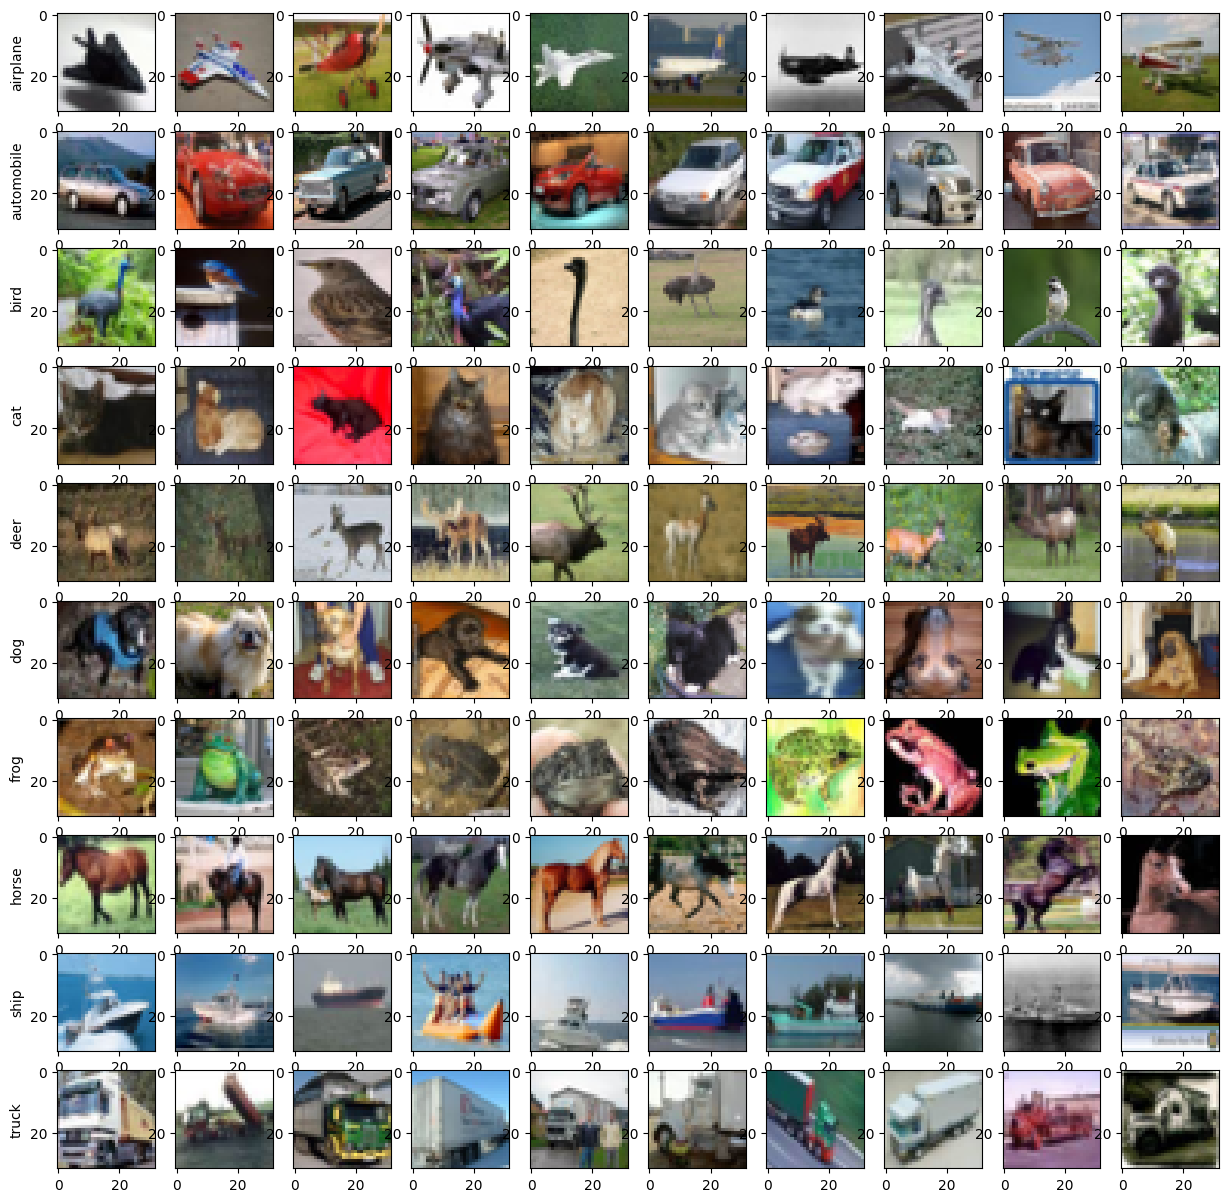

In [ ]:
fig, ax = plt.subplots(len(cifar10.classes), 10, figsize=(15, len(cifar10.classes) * 1.5))

for i in range(ax.shape[0]):
    ax[i, 0].set_ylabel(cifar10.classes[i])
    indices = np.where(Y == i)[0]

    for j in range(ax.shape[1]):
        ax[i, j].imshow(X[indices[j]].transpose(1, 2, 0))

plt.show()

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=224, stratify=Y)

print("shape:", X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape)

shape: (40000, 3, 32, 32) (10000, 3, 32, 32) (40000,) (10000,)


In [ ]:
cifar10_test = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=T.ToTensor()
)

X_test, Y_test = zip(*list(iter(cifar10_test)))
X_test = np.array([x.numpy() for x in X_test])
Y_test = np.array(Y_test)

print("shape:", X_test.shape, Y_test.shape)
print("max/min of X:", X_test.max(), X_test.min())

Files already downloaded and verified
shape: (10000, 3, 32, 32) (10000,)
max/min of X: 1.0 0.0


In [ ]:
class CIFAR10Dataset(Dataset):
    def __init__(self, X_data, Y_data, device='cpu', transform=None):
        self.X = torch.FloatTensor(X_data).to(device)
        self.Y = torch.LongTensor(Y_data).to(device)
        self.transform = None

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        x = self.X[item]
        y = self.Y[item]

        if self.transform:
            x = self.transform(x)

        return x, y

    def unpack(self):
        X, Y = self.X, self.Y

        if self.transform:
            X = np.vectorize(lambda x: self.transform(x))(X)

        return X, Y

In [ ]:
transform = T.ToTensor()

train_dset = CIFAR10Dataset(X_data=X_train, Y_data=Y_train, device=device, transform=transform)
valid_dset = CIFAR10Dataset(X_data=X_valid, Y_data=Y_valid, device=device, transform=transform)
test_dset = CIFAR10Dataset(X_data=X_test, Y_data=Y_test, device=device, transform=transform)

print("len:", len(train_dset), len(valid_dset), len(test_dset))

len: 40000 10000 10000


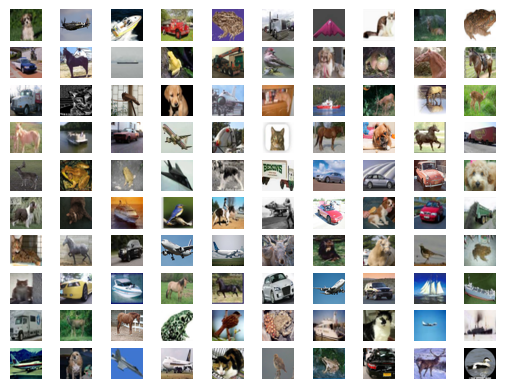

In [ ]:
for i in range(1, 100 + 1):
    plt.subplot(10, 10, i)
    plt.imshow(train_dset[i][0].cpu().permute(1, 2, 0))
    plt.axis('off')

plt.show()

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=True, drop_last=True)

print("len:", len(train_loader), len(valid_loader))

len: 1250 312


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        layers = [
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.dropout,
            self.pool
        ]

        for layer in layers:
            x = layer(x)

        return x


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.block1 = BasicBlock(3, 16, 32)
        self.block2 = BasicBlock(32, 64, 128)
        self.block3 = BasicBlock(128, 256, 512)

        self.fc1 = nn.Linear(512*4*4, 256*2*2)
        self.fc2 = nn.Linear(256*2*2, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()
        self.flatten = lambda x: torch.flatten(x, start_dim=1)

    def forward(self, x):
        layers = [
            self.block1,
            self.block2,
            self.block3,
            self.flatten,
            self.fc1,
            self.relu,
            self.fc2,
            self.relu,
            self.fc3
        ]

        for layer in layers:
            x = layer(x)

        return x

In [ ]:
epochs = 100
lr = 0.001

model = CNN(num_classes=len(cifar10.classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
cost = nn.CrossEntropyLoss().to(device)

In [ ]:
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
              ReLU-4           [-1, 32, 32, 32]               0
           Dropout-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
        BasicBlock-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
             ReLU-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
        MaxPool2d-13            [-1, 128, 8, 8]               0
       BasicBlock-14            [-1, 12

In [ ]:
@dataclass
class EpochStatus:
    epoch: int = None
    valid_loss: float = inf
    model_state: dict = None

    def __bool__(self):
        return bool(self.epoch)

best = EpochStatus()
before = EpochStatus()
overfit_streak = 0
patience = 5

for epoch in range(epochs):
    print(f"=== Epoch {epoch + 1:02d}/{epochs:02d} =========================")

    with tqdm(train_loader, unit='batch') as train:
        train.set_description("Train")

        train_loss = 0
        for x, y in train:
            optimizer.zero_grad()
            predict = model(x)
            loss = cost(predict, y)
            loss.backward()
            train_loss += loss.item() / len(train)
            optimizer.step()

            train.set_postfix(loss=train_loss)

    with tqdm(valid_loader, unit='batch') as valid:
        valid.set_description("Valid")

        valid_loss = 0
        for x, y in valid:
            optimizer.zero_grad()
            predict = model(x)
            loss = cost(predict, y)
            loss.backward()
            valid_loss += loss.item() / len(valid)
            optimizer.step()

            valid.set_postfix(loss=valid_loss, overfit_streak=overfit_streak)

    if best.valid_loss > valid_loss:
        best = EpochStatus(epoch=epoch, valid_loss=valid_loss, model_state=model.state_dict())

    if before:
        if before.valid_loss < valid_loss:
            overfit_streak += 1
        else:
            overfit_streak = 0

    if overfit_streak >= patience:
        print("Early Stopping...")
        break

    before = EpochStatus(epoch=epoch, valid_loss=valid_loss, model_state=model.state_dict())

print(f"=========================================\n")

print(f"Best Model: [epoch={best.epoch + 1}, loss={best.valid_loss}]")
torch.save(best.model_state, 'best_model.pth')

=== Epoch 01/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.43batch/s, loss=1.46, overfit_streak=0]


=== Epoch 02/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.61batch/s, loss=1.22, overfit_streak=0]


=== Epoch 03/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.89batch/s, loss=1.08, overfit_streak=0]


=== Epoch 04/100 =========================


Valid: 100%|██████████| 312/312 [00:02<00:00, 104.14batch/s, loss=0.988, overfit_streak=0]


=== Epoch 05/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.97batch/s, loss=0.915, overfit_streak=0]


=== Epoch 06/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.91batch/s, loss=0.851, overfit_streak=0]


=== Epoch 07/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 103.05batch/s, loss=0.797, overfit_streak=0]


=== Epoch 08/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.37batch/s, loss=0.773, overfit_streak=0]


=== Epoch 09/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 103.72batch/s, loss=0.731, overfit_streak=0]


=== Epoch 10/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.73batch/s, loss=0.687, overfit_streak=0]


=== Epoch 11/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.93batch/s, loss=0.683, overfit_streak=0] 


=== Epoch 12/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.96batch/s, loss=0.675, overfit_streak=0]


=== Epoch 13/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.02batch/s, loss=0.64, overfit_streak=0]


=== Epoch 14/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.11batch/s, loss=0.607, overfit_streak=0]


=== Epoch 15/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 102.49batch/s, loss=0.596, overfit_streak=0]


=== Epoch 16/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 101.43batch/s, loss=0.588, overfit_streak=0]


=== Epoch 17/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 101.69batch/s, loss=0.563, overfit_streak=0]


=== Epoch 18/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 101.39batch/s, loss=0.548, overfit_streak=0]


=== Epoch 19/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 101.36batch/s, loss=0.526, overfit_streak=0]


=== Epoch 20/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 101.55batch/s, loss=0.514, overfit_streak=0]


=== Epoch 21/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.43batch/s, loss=0.533, overfit_streak=0]


=== Epoch 22/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.08batch/s, loss=0.492, overfit_streak=1]


=== Epoch 23/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 96.34batch/s, loss=0.474, overfit_streak=0]


=== Epoch 24/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.31batch/s, loss=0.488, overfit_streak=0]


=== Epoch 25/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 96.71batch/s, loss=0.45, overfit_streak=1]


=== Epoch 26/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.29batch/s, loss=0.463, overfit_streak=0]


=== Epoch 27/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 96.34batch/s, loss=0.456, overfit_streak=1]


=== Epoch 28/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 94.45batch/s, loss=0.432, overfit_streak=0]


=== Epoch 29/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.50batch/s, loss=0.444, overfit_streak=0]


=== Epoch 30/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 96.03batch/s, loss=0.408, overfit_streak=1]


=== Epoch 31/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 95.71batch/s, loss=0.438, overfit_streak=0]


=== Epoch 32/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 96.72batch/s, loss=0.415, overfit_streak=1]


=== Epoch 33/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 93.88batch/s, loss=0.388, overfit_streak=0]


=== Epoch 34/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 96.54batch/s, loss=0.403, overfit_streak=0] 


=== Epoch 35/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.41batch/s, loss=0.369, overfit_streak=1]


=== Epoch 36/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 96.22batch/s, loss=0.376, overfit_streak=0] 


=== Epoch 37/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.73batch/s, loss=0.351, overfit_streak=1] 


=== Epoch 38/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.48batch/s, loss=0.351, overfit_streak=0] 


=== Epoch 39/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.61batch/s, loss=0.332, overfit_streak=0]


=== Epoch 40/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.07batch/s, loss=0.346, overfit_streak=0]


=== Epoch 41/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.74batch/s, loss=0.318, overfit_streak=1]


=== Epoch 42/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.48batch/s, loss=0.346, overfit_streak=0]


=== Epoch 43/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.72batch/s, loss=0.352, overfit_streak=1]


=== Epoch 44/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 101.17batch/s, loss=0.323, overfit_streak=2]


=== Epoch 45/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.38batch/s, loss=0.332, overfit_streak=0]


=== Epoch 46/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.96batch/s, loss=0.296, overfit_streak=1]


=== Epoch 47/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.24batch/s, loss=0.299, overfit_streak=0]


=== Epoch 48/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.94batch/s, loss=0.29, overfit_streak=1]


=== Epoch 49/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.22batch/s, loss=0.307, overfit_streak=0]


=== Epoch 50/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.70batch/s, loss=0.283, overfit_streak=1]


=== Epoch 51/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.91batch/s, loss=0.247, overfit_streak=0]


=== Epoch 52/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.60batch/s, loss=0.272, overfit_streak=0]


=== Epoch 53/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.71batch/s, loss=0.266, overfit_streak=1] 


=== Epoch 54/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.89batch/s, loss=0.256, overfit_streak=0]


=== Epoch 55/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.19batch/s, loss=0.292, overfit_streak=0]


=== Epoch 56/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.98batch/s, loss=0.275, overfit_streak=1]


=== Epoch 57/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.33batch/s, loss=0.284, overfit_streak=0]


=== Epoch 58/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.17batch/s, loss=0.273, overfit_streak=1] 


=== Epoch 59/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 101.43batch/s, loss=0.272, overfit_streak=0]


=== Epoch 60/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.35batch/s, loss=0.268, overfit_streak=0]


=== Epoch 61/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.68batch/s, loss=0.277, overfit_streak=0]


=== Epoch 62/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.72batch/s, loss=0.272, overfit_streak=1]


=== Epoch 63/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 96.30batch/s, loss=0.262, overfit_streak=0]


=== Epoch 64/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.02batch/s, loss=0.232, overfit_streak=0]


=== Epoch 65/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.33batch/s, loss=0.232, overfit_streak=0]


=== Epoch 66/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.09batch/s, loss=0.249, overfit_streak=0]


=== Epoch 67/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.37batch/s, loss=0.241, overfit_streak=1]


=== Epoch 68/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.89batch/s, loss=0.24, overfit_streak=0]


=== Epoch 69/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.65batch/s, loss=0.252, overfit_streak=0] 


=== Epoch 70/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.19batch/s, loss=0.222, overfit_streak=1]


=== Epoch 71/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.23batch/s, loss=0.233, overfit_streak=0]


=== Epoch 72/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.69batch/s, loss=0.257, overfit_streak=1] 


=== Epoch 73/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.05batch/s, loss=0.25, overfit_streak=2]


=== Epoch 74/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.85batch/s, loss=0.264, overfit_streak=0]


=== Epoch 75/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.93batch/s, loss=0.225, overfit_streak=1] 


=== Epoch 76/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.24batch/s, loss=0.287, overfit_streak=0]


=== Epoch 77/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.45batch/s, loss=0.253, overfit_streak=1]


=== Epoch 78/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.81batch/s, loss=0.247, overfit_streak=0]


=== Epoch 79/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.10batch/s, loss=0.254, overfit_streak=0]


=== Epoch 80/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.12batch/s, loss=0.239, overfit_streak=1]


=== Epoch 81/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.80batch/s, loss=0.253, overfit_streak=0] 


=== Epoch 82/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.81batch/s, loss=0.257, overfit_streak=1]


=== Epoch 83/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.49batch/s, loss=0.211, overfit_streak=2]


=== Epoch 84/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 96.61batch/s, loss=0.26, overfit_streak=0]


=== Epoch 85/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.79batch/s, loss=0.221, overfit_streak=1]


=== Epoch 86/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.30batch/s, loss=0.224, overfit_streak=0]


=== Epoch 87/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.67batch/s, loss=0.19, overfit_streak=1] 


=== Epoch 88/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.41batch/s, loss=0.195, overfit_streak=0]


=== Epoch 89/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.66batch/s, loss=0.214, overfit_streak=1] 


=== Epoch 90/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 97.83batch/s, loss=0.219, overfit_streak=2]


=== Epoch 91/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.78batch/s, loss=0.259, overfit_streak=3]


=== Epoch 92/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.98batch/s, loss=0.245, overfit_streak=4] 


=== Epoch 93/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 100.27batch/s, loss=0.209, overfit_streak=0]


=== Epoch 94/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.73batch/s, loss=0.208, overfit_streak=0]


=== Epoch 95/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 99.52batch/s, loss=0.246, overfit_streak=0]


=== Epoch 96/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.48batch/s, loss=0.221, overfit_streak=1]


=== Epoch 97/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 98.03batch/s, loss=0.299, overfit_streak=0] 


=== Epoch 98/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 95.53batch/s, loss=0.174, overfit_streak=1]


=== Epoch 99/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 95.89batch/s, loss=0.211, overfit_streak=0]


=== Epoch 100/100 =========================


Valid: 100%|██████████| 312/312 [00:03<00:00, 94.00batch/s, loss=0.214, overfit_streak=1]



Best Model: [epoch=98, loss=0.1740041469725278]


In [ ]:
best_model = CNN(num_classes=len(cifar10.classes)).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

if isinstance(X_test, np.ndarray) and isinstance(Y_test, np.ndarray):
    X_test, Y_test = test_dset.unpack()

with torch.no_grad():
    predict = model(X_test).argmax(dim=1)
    is_correct = predict == Y_test

    print(f"Model Accuracy: {is_correct.float().mean()}")

Model Accuracy: 0.7426999807357788
